<a href="https://colab.research.google.com/github/maksim267/Language_modelling/blob/main/hw_language_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [6]:
sentences = []
word_threshold = 100

for i in tqdm(dataset["train"]['text']):
  sentences.extend([x.lower() for x in sent_tokenize(i,language='english') if len(x)<word_threshold])
# Получить отдельные предложения и поместить их в sentences

  0%|          | 0/25000 [00:00<?, ?it/s]

In [7]:
print("Всего предложений:", len(sentences))

Всего предложений: 139933


Посчитаем для каждого слова его встречаемость.

In [8]:
words = Counter()

for sentence in tqdm(sentences):
    for char in word_tokenize(sentence):
        words[char] += 1

# Расчет встречаемости слов

  0%|          | 0/139933 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [9]:
len(words)

46606

In [10]:

vocab_size = 40000

vocab = set(x for x, _ in words.most_common(vocab_size))
vocab.update(['<unk>', '<bos>', '<eos>', '<pad>'])
# Наполнение словаря

In [11]:
len(vocab)

40004

In [12]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [13]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [14]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [15]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence+=[word2ind.get(x,self.unk_id) for x in word_tokenize(self.data[idx])]
        tokenized_sentence+=[self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [16]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [17]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [18]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1) # Посчитайте логиты предсказаний следующих слов
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [19]:
def train_model(model, optimizer, criterion, train_dataloader, num_epoch=10):
    losses=[]
    scores=[]
    for epoch in range(num_epoch):
        model.train()
        epoch_losses=[]
        for batch in tqdm(train_dataloader, desc=f'Эпоха №{epoch}'):
            optimizer.zero_grad()
            logits=model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss=criterion(logits,batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss)
        losses.append(sum(epoch_losses)/len(epoch_losses))
        scores.append(evaluate(model, criterion,eval_dataloader))
        print(f'Перфлексия на тренировчных данных:{losses[-1]},\nПерфлексия на валидационных данных:{scores[-1]}')
    return losses, scores

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [123]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embeding=nn.Embedding(vocab_size, hidden_dim)
        self.rnn=nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear=nn.Linear(hidden_dim, hidden_dim)
        self.output_lin=nn.Linear(hidden_dim, vocab_size)

        self.act_fun=nn.Tanh()
        self.dropout=nn.Dropout(p=0.1)
        # Опишите свою нейронную сеть здесь

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embeding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.act_fun(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.output_lin(self.act_fun(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [124]:
model=LanguageModel(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [125]:
loss_train, loss_val=train_model(model, optimizer, criterion, train_dataloader, num_epoch=50)

Эпоха №0:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:2.663273334503174,
Перфлексия на валидационных данных:10.45442542471877


Эпоха №1:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:2.2634620666503906,
Перфлексия на валидационных данных:9.00954645904806


Эпоха №2:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:2.145125150680542,
Перфлексия на валидационных данных:8.24300188338299


Эпоха №3:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:2.0571329593658447,
Перфлексия на валидационных данных:7.745973502042307


Эпоха №4:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.9835901260375977,
Перфлексия на валидационных данных:7.381612269054601


Эпоха №5:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.919495940208435,
Перфлексия на валидационных данных:7.105767108404658


Эпоха №6:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.8630365133285522,
Перфлексия на валидационных данных:6.893535606603954


Эпоха №7:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.8129985332489014,
Перфлексия на валидационных данных:6.717239517616398


Эпоха №8:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.7693190574645996,
Перфлексия на валидационных данных:6.580722252237296


Эпоха №9:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.7302885055541992,
Перфлексия на валидационных данных:6.464812929931027


Эпоха №10:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.695846676826477,
Перфлексия на валидационных данных:6.377372156331482


Эпоха №11:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.6650322675704956,
Перфлексия на валидационных данных:6.278878225051071


Эпоха №12:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.6372097730636597,
Перфлексия на валидационных данных:6.206721333306712


Эпоха №13:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.6121320724487305,
Перфлексия на валидационных данных:6.137900865492045


Эпоха №14:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.5894241333007812,
Перфлексия на валидационных данных:6.09261522214635


Эпоха №15:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.5692108869552612,
Перфлексия на валидационных данных:6.060766874327302


Эпоха №16:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.550057291984558,
Перфлексия на валидационных данных:6.017510575829737


Эпоха №17:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.5326143503189087,
Перфлексия на валидационных данных:5.9695017211398


Эпоха №18:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.5174580812454224,
Перфлексия на валидационных данных:5.934123580155033


Эпоха №19:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.5032219886779785,
Перфлексия на валидационных данных:5.915212113417045


Эпоха №20:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.4902195930480957,
Перфлексия на валидационных данных:5.882838799269152


Эпоха №21:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.4782770872116089,
Перфлексия на валидационных данных:5.875685188408526


Эпоха №22:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.4670348167419434,
Перфлексия на валидационных данных:5.852389553565212


Эпоха №23:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.4562273025512695,
Перфлексия на валидационных данных:5.856122022137128


Эпоха №24:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.44693124294281,
Перфлексия на валидационных данных:5.828241472488347


Эпоха №25:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.4376721382141113,
Перфлексия на валидационных данных:5.8230885238926415


Эпоха №26:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.4292641878128052,
Перфлексия на валидационных данных:5.796972462638423


Эпоха №27:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.421799659729004,
Перфлексия на валидационных данных:5.772497471333422


Эпоха №28:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.4132094383239746,
Перфлексия на валидационных данных:5.7719462554241225


Эпоха №29:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.4070571660995483,
Перфлексия на валидационных данных:5.752025938992962


Эпоха №30:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.40033757686615,
Перфлексия на валидационных данных:5.734585595087334


Эпоха №31:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.3941375017166138,
Перфлексия на валидационных данных:5.727861802800264


Эпоха №32:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.3875983953475952,
Перфлексия на валидационных данных:5.731890485753089


Эпоха №33:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.3825219869613647,
Перфлексия на валидационных данных:5.718201258936573


Эпоха №34:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.376278281211853,
Перфлексия на валидационных данных:5.715165975978649


Эпоха №35:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.3704547882080078,
Перфлексия на валидационных данных:5.704430595394462


Эпоха №36:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.3665294647216797,
Перфлексия на валидационных данных:5.694837616828067


Эпоха №37:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.3617321252822876,
Перфлексия на валидационных данных:5.673331571889316


Эпоха №38:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.3570085763931274,
Перфлексия на валидационных данных:5.658659296890064


Эпоха №39:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.352764368057251,
Перфлексия на валидационных данных:5.661770810156897


Эпоха №40:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.3482520580291748,
Перфлексия на валидационных данных:5.642139610032495


Эпоха №41:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.3444539308547974,
Перфлексия на валидационных данных:5.638271055884074


Эпоха №42:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.339936375617981,
Перфлексия на валидационных данных:5.642929350436279


Эпоха №43:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.336342453956604,
Перфлексия на валидационных данных:5.647477105940935


Эпоха №44:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.3328516483306885,
Перфлексия на валидационных данных:5.622754232539119


Эпоха №45:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.3289835453033447,
Перфлексия на валидационных данных:5.630180113494287


Эпоха №46:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.3258179426193237,
Перфлексия на валидационных данных:5.6424844979804005


Эпоха №47:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.3222306966781616,
Перфлексия на валидационных данных:5.632001883804907


Эпоха №48:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.3193548917770386,
Перфлексия на валидационных данных:5.637977143310324


Эпоха №49:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.3153141736984253,
Перфлексия на валидационных данных:5.633263663792305


In [126]:
loss_train = [v.cpu().item() for v in loss_train]

Лучшая перфлексия для подхода train: 1.32
Лучшая перфлексия для подхода validation: 5.62


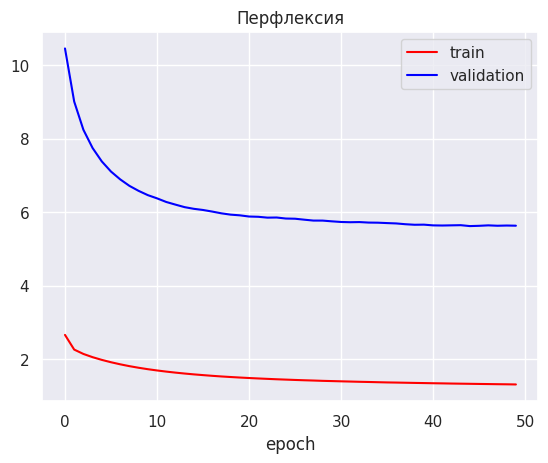

In [127]:
for (name, values), color in zip([('train',loss_train),('validation',loss_val)], ['red', 'blue']):
    plt.plot(np.arange(len(values)), values, color=color, label=name)
    print(f"Лучшая перфлексия для подхода {name}: {(min(values)):.2f}")

plt.title('Перфлексия')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(word, word2ind['<unk>']) for word in word_tokenize(starting_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_word_distribution = model(input_ids)[-1]
            next_word = next_word_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind['<eos>']:
                break

    words = ' '.join([ind2word[idx.item()] if ind2word[idx.item()] not in ('<bos>','<eos>') else '' for idx in input_ids])

    return words

In [129]:
generate_sequence(model, starting_seq='My perfect fruit is')

" <unk> perfect fruit is n't even worth the time . "

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [20]:
class LanguageModel2(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embeding=nn.Embedding(vocab_size, hidden_dim)
        self.rnn=nn.LSTM(hidden_dim, hidden_dim, batch_first=True,num_layers=2)
        self.linear=nn.Linear(hidden_dim, hidden_dim)
        self.output_lin=nn.Linear(hidden_dim, vocab_size)

        self.act_fun=nn.Tanh()
        self.dropout=nn.Dropout(p=0.1)
        # Опишите свою нейронную сеть здесь

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embeding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.act_fun(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.output_lin(self.act_fun(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [21]:
model=LanguageModel2(hidden_dim=512, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
loss_train2, loss_val2=train_model(model, optimizer, criterion, train_dataloader, num_epoch=50)

Эпоха №0:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:5.598569869995117,
Перфлексия на валидационных данных:134.19469993075245


Эпоха №1:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:4.721092700958252,
Перфлексия на валидационных данных:89.86841463301691


Эпоха №2:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:4.4037251472473145,
Перфлексия на валидационных данных:74.09277959541167


Эпоха №3:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:4.175168991088867,
Перфлексия на валидационных данных:65.02498234081094


Эпоха №4:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:3.974163293838501,
Перфлексия на валидационных данных:58.73500641259676


Эпоха №5:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:3.7933616638183594,
Перфлексия на валидационных данных:54.97112113771317


Эпоха №6:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:3.6317670345306396,
Перфлексия на валидационных данных:49.99962648743903


Эпоха №7:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:3.484879493713379,
Перфлексия на валидационных данных:47.38804143176872


Эпоха №8:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:3.3530895709991455,
Перфлексия на валидационных данных:45.71070955266028


Эпоха №9:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:3.233212947845459,
Перфлексия на валидационных данных:43.61762948533081


Эпоха №10:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:3.115299701690674,
Перфлексия на валидационных данных:43.960493760745315


Эпоха №11:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:3.007453203201294,
Перфлексия на валидационных данных:42.69751259700907


Эпоха №12:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:2.91097354888916,
Перфлексия на валидационных данных:41.64007288359201


Эпоха №13:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:2.8237709999084473,
Перфлексия на валидационных данных:40.83697940401011


Эпоха №14:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:2.7469146251678467,
Перфлексия на валидационных данных:39.91639962972191


Эпоха №15:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:2.666261672973633,
Перфлексия на валидационных данных:40.100833195437026


Эпоха №16:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:2.591771364212036,
Перфлексия на валидационных данных:39.481707979163915


Эпоха №17:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:2.520670175552368,
Перфлексия на валидационных данных:40.10411385600702


Эпоха №18:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:2.4533207416534424,
Перфлексия на валидационных данных:41.624373099485744


Эпоха №19:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:2.392822265625,
Перфлексия на валидационных данных:41.21799509442484


Эпоха №20:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:2.337080955505371,
Перфлексия на валидационных данных:41.22462930278325


Эпоха №21:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:2.2816805839538574,
Перфлексия на валидационных данных:41.47133676225568


Эпоха №22:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:2.231520175933838,
Перфлексия на валидационных данных:41.381890218480194


Эпоха №23:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:2.1848058700561523,
Перфлексия на валидационных данных:41.47796425828114


Эпоха №24:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:2.140839099884033,
Перфлексия на валидационных данных:41.89495577629131


Эпоха №25:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:2.097113847732544,
Перфлексия на валидационных данных:42.42246933262353


Эпоха №26:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:2.060354232788086,
Перфлексия на валидационных данных:42.695970584095285


Эпоха №27:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:2.022101879119873,
Перфлексия на валидационных данных:43.37690314688674


Эпоха №28:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.9883707761764526,
Перфлексия на валидационных данных:44.50021369975925


Эпоха №29:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.9566453695297241,
Перфлексия на валидационных данных:45.37417880795773


Эпоха №30:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.9254895448684692,
Перфлексия на валидационных данных:44.85357719714288


Эпоха №31:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.8921945095062256,
Перфлексия на валидационных данных:44.74404072107737


Эпоха №32:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.8619024753570557,
Перфлексия на валидационных данных:45.16891816677951


Эпоха №33:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.8338884115219116,
Перфлексия на валидационных данных:45.6612922103575


Эпоха №34:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.8111991882324219,
Перфлексия на валидационных данных:46.813980684855736


Эпоха №35:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.787774920463562,
Перфлексия на валидационных данных:46.42771950674667


Эпоха №36:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.7658658027648926,
Перфлексия на валидационных данных:46.61336179450835


Эпоха №37:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.7407865524291992,
Перфлексия на валидационных данных:46.869872206525784


Эпоха №38:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.717490792274475,
Перфлексия на валидационных данных:47.37867128696477


Эпоха №39:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.699283242225647,
Перфлексия на валидационных данных:48.15111337762864


Эпоха №40:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.6782946586608887,
Перфлексия на валидационных данных:48.76466748309092


Эпоха №41:   0%|          | 0/875 [00:00<?, ?it/s]

Перфлексия на тренировчных данных:1.6591161489486694,
Перфлексия на валидационных данных:50.361188107478334


Эпоха №42:   0%|          | 0/875 [00:00<?, ?it/s]

In [ ]:
loss_train2 = [v.cpu().item() for v in loss_train]

In [ ]:
for (name, values), color in zip([('train',loss_train2),('validation',loss_val2)], ['red', 'blue']):
    plt.plot(np.arange(len(values)), values, color=color, label=name)
    print(f"Лучшая перфлексия для подхода {name}: {(min(values)):.2f}")

plt.title('Перфлексия')
plt.xlabel("epoch")
plt.legend()
plt.show()

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

Были проведены эксперименты с увеличением словаря, внутренней размерности слоев, колличества эпох, разными вариантами слоев rnn (GRU, LSTM) и их количеством. При увеличении количества слов в словаре перфлексия выросла и генерация показывает более осмысленные результаты. При увеличении внутренней размерности словаря мы получили существенное увеличение продолжительности обучения и небольшой выйгрыш в перфлексии. После первого запуска модели на 10 эпохах было понятно что такого количества не хватает и так как до увеличения внутренней размерности обучение происходило быстро то эксперементальным методом под количество эпох было увеличено до 40-50. По итогу выбора моделей более быстрая GRU и с меньшей внутренней размерностью и одним рекурентным слоем оказалась выше чем у LSTM с двумя рекурентными слоями что слишком усложнило общую архитектуру, общая перфлексия на валидационном датасете сильно хуже чем у GRU.